# OU REVISITED
In this notebook I wil once again use the OU model as a framework for a statistical arbitrage model, however this time i will generate the weights using a feedforward neural network instead of a static rule based system as before, also allowing me to incorporate transaction costs in the training of the strategy

### 0) Imports and other preparations

In [1]:
LOOKBACK_PERIOD = 192 #2 days is the total lookback period 

In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import torch
from numpy.linalg import eig, norm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time

In [37]:
pct_ret = pd.read_csv('pct_returns.csv').set_index('close_time')
pct_ret = pct_ret[len(pct_ret)//2:]
#log_ret = pd.read_csv('log_returns.csv').set_index('close_time')[1:len(pct_ret)//2]

In [41]:
#there is a value with 200000% return remove it

0.4017561920910797
0.1553973902728351
0.265625
0.5870535714285714
0.149896694214876
0.1595547309833025
0.1363004172461752
0.1968152866242039
0.1684225362037983
0.1616438356164384
0.1522556390977443
0.8232022248708779
0.375
0.7027027027027029
0.3317238679368393
0.1408259986459039
0.1727941176470586
0.8012552301255231
0.1530201342281878
0.1631836371720765
0.4755838641188958
0.1626360338573156
0.3872832369942196
0.1185495118549511
0.7519426180514046
0.3915770609318993
0.1321218074656189
0.769811320754717
0.1473867595818816
0.8437324339516581
0.105596107055961
0.2779170489797702
0.1133004926108374
0.440022188323395
0.1776584867075665
1.0009278755219295
0.1083489681050655
0.2228571428571428
0.1674167416741674
0.185840707964602
0.4002550965722737
0.4022388815722824
0.2124582869855396
0.4138513513513513
0.5341922695738357
0.1742574257425742
0.6675503711558857
0.4003218668276003
1.1189269746646795
0.1818766066838046
0.1997105643994212
0.1526946107784432
5.070525291828795
0.1618783435704378
0.2

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### 1) Generating the residual portfolios

This is currently done using a pca method as described in Avalanda and Lee (2008), however in the future newer techniques could be used like the one decribed in this paper: Two Machine Learning Approaches for Statistical Arbitrage Pairs Selection. based upon: Deep Clustering with Convolutional Autoencoders, by Xifeng Guo et al. 

In [22]:
def pca(returns:pd.DataFrame, res_cov_window_size:int = 252, loadings_window_size:int=30, amount_of_factors:int=5):
    '''
    Function that computes the percentage returns of a residual portfolio constructed using pca
    Also with the weights needed to construct all these portfolio's
    
    Residual_output  is a T x N matrix 
    Residual_portfolio is a T x N x N matrix where e.g res_portf[t,i, :] gives you the vector 
    with all the weights you need to construct the residual portfolio i at timestep t
    Recovering phi from residual portfolio can be done by slicing as follows res_portf[t,:,:]
    '''
    T, N                = returns.shape
    returns             = returns.to_numpy()
    residuals_output    = np.zeros((T, N), dtype=float)    
    residual_portfolio  = np.zeros((T, N, N), dtype=float)
    for t in range(res_cov_window_size+1,len(returns)):
        # only use the columns with no missing values
        idxsSelected = ~np.any(np.isnan(returns[(t - res_cov_window_size+1):t]), axis = 0).ravel()   
        if idxsSelected.sum() == 0:
            continue
        #calculate covariance
        res_cov_window = returns[(t - res_cov_window_size+1):t,idxsSelected]
        R_OoS           = returns[(t - res_cov_window_size+1):(t+1),idxsSelected] #TODO: adj for bias, original returns[(t - res_cov_window_size+1):(t+1),idxsSelected]
        res_mean = np.mean(res_cov_window,axis=0,keepdims=True)
        res_vol = np.sqrt(np.mean((res_cov_window-res_mean)**2,axis=0,keepdims=True))
        res_normalized = (res_cov_window - res_mean) / res_vol
        Corr = np.dot(res_normalized.T, res_normalized)
        eigenValues, eigenVectors = np.linalg.eigh(Corr)

        #calculate loadings
        w           = eigenVectors[:,-amount_of_factors:].real                      # w
        R           = res_cov_window[-loadings_window_size:,:]
        wtR         = res_cov_window[-loadings_window_size:,:] @ w                  # R * w 
        regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)   
        beta        = regr.coef_                                                    #beta
        phi         = (np.eye(beta.shape[0]) - beta @ w.T)
        #TODO: is ther somethign wrong with the returns they use here??
        residuals   = phi @ R[-1,:].T
        residuals_output[t:(t+1),idxsSelected]                = residuals
        i = 0
        for idx, val in enumerate(idxsSelected):
            if val:  
                residual_portfolio[t:(t+1),idx,idxsSelected] = phi[i,:].reshape([1,-1])
                i += 1  
    return residuals_output, residual_portfolio

In [23]:
test                      = pct_ret
PCA, pca_portfolio        = pca(test) 
residuals                 = pd.DataFrame(PCA, index=test.index, columns=test.columns)

In [24]:
residuals

,APEUSDT,RUNEUSDT,JASMYUSDT,FORTHUSDT,NEARUSDT,AAVEUSDT,DOTUSDT,DOGEUSDT,ROSEUSDT,FILUSDT,...,ONEUSDT,ADAUSDT,KNCUSDT,WINGUSDT,XRPUSDT,RADUSDT,XLMUSDT,AXSUSDT,GALAUSDT,MATICUSDT
close_time,,,,,,,,,,,,,,,,,,,,,
2021-12-05 08:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-12-05 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-12-05 16:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-12-05 20:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-12-06 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 08:00:00,-0.000565,0.001160,-0.001245,0.005631,-0.006993,-0.002061,0.001141,-0.001447,-0.000253,-0.007396,...,0.010451,0.000083,-0.026582,0.001541,-0.008399,0.010272,0.002949,0.009915,0.000999,-0.005473
2022-08-31 12:00:00,-0.003882,0.009767,0.003231,-0.014463,-0.002803,-0.005426,0.003745,0.006365,0.001995,-0.005532,...,0.012897,-0.007047,0.006861,0.008534,0.002526,-0.002968,-0.004062,-0.002688,-0.003237,-0.000755
2022-08-31 16:00:00,-0.002580,-0.004102,-0.004274,0.003427,0.008573,0.003871,0.000098,-0.000313,0.004053,0.002025,...,0.004814,-0.005331,0.003691,0.009036,0.010311,0.002684,0.003810,0.005495,-0.003120,-0.006442


### 2) Preprocessing the OU signals

In [25]:
def preprocess_ou(data:np.array, lookback:int=30):
    print("Start OU preprocess")
    signal_length = 4
    T,N = data.shape
    cumsums = np.cumsum(data, axis=0)
    windows = np.zeros((T-lookback, N, signal_length), dtype=np.float32)
    idxs_selected = np.zeros((T-lookback,N), dtype=bool)
    for t in range(lookback,T):
        # chooses stocks which have no missing returns in the t-th lookback window
        idxs_selected[t-lookback,:] = ~np.any(data[(t-lookback):t,:] == 0, axis=0).ravel() 
        idxs = idxs_selected[t-lookback,:]
        if t == lookback:
            x = cumsums[t-lookback:t,idxs].T
        else:
            # Probably unnecessary given the conv normalization, but is just to have the same setting as in the OU case
            x = cumsums[t-lookback:t,idxs].T - cumsums[t-lookback-1,idxs].reshape(int(sum(idxs)),1)
        Nx,Tx = x.shape
        #TODO: Is this where we make sure we dont have any look ahead bias?
        Ys = x[:,1:] #(N,T-1) 
        Xs = x[:,:-1]
        meansX = np.mean(Xs,axis=1) #(N)
        meansY = np.mean(Ys,axis=1)
        VarsX = np.var(Xs,axis=1) #N
        VarsY = np.var(Ys,axis=1)
        Covs = np.mean((Xs-meansX.reshape((Nx,1)))*(Ys-meansY.reshape((Nx,1))),axis=1) #N
        R2 = Covs**2/(VarsX*VarsY) #N
        bs = Covs/VarsX #N
        cs = (meansY - bs*meansX)
        mus = (cs/(1-bs+0.000001))
        mask = ((bs > 0) * (bs < 1))
        #kappas = -np.log(bs)/Deltat #if bs betwen 0 and 1
        residuals = Ys - bs.reshape((Nx,1))*Xs - cs.reshape((Nx,1)) #(N,T-1)
        sigmas = np.sqrt(np.var(residuals, axis=1)/np.abs(1-bs**2+0.000001)) #N
        signal = np.zeros((Nx))
        #signal =  (mus - Ys[:,-1])/sigmas * mask 
        signal[mask] = (mus[mask] - Ys[:,-1][mask])/sigmas[mask]
        windows[t-lookback,idxs,0] = Ys[:,-1]
        windows[t-lookback,idxs,1] = mus
        windows[t-lookback,idxs,2] = sigmas
        windows[t-lookback,idxs,3] = R2
#         if (t-lookback) % 100 == 0:
#             logging.info(f"idxs_selected before & mask: {np.sum(idxs_selected[t-lookback,:])}")
        idxs_selected[t-lookback,idxs] = idxs_selected[t-lookback,idxs] & mask
#         if (t-lookback) % 100 == 0:
#             logging.info(f"idxs_selected after & mask: {np.sum(idxs_selected[t-lookback,:])}")
    idxs_selected = torch.as_tensor(idxs_selected)
    print("Finish OU preprocess")
    return windows, idxs_selected

In [26]:
windows, idxs_selected = preprocess_ou(PCA, 30)
windows.shape #AXIS 0: time t, AXIS 1: asset, AXIS 2: signal value, mu, sigma, R2

Start OU preprocess
Finish OU preprocess


(1589, 94, 4)

(-2.0, 2.0)

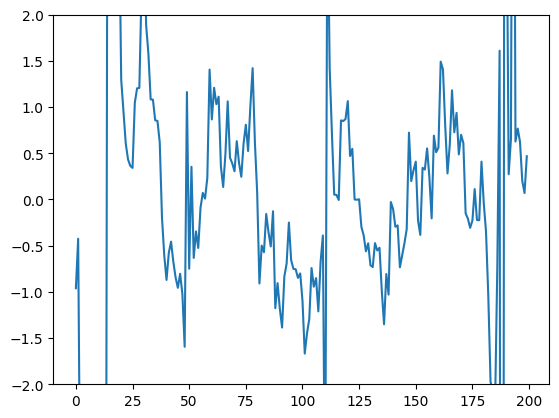

In [27]:
# following plot shows the generated signal for RUNEUSDT
# judging by this plot it looks pretty solid
plt.plot(((windows[-200:,1,0] - windows[-200:,1,1]) / windows[-200:,1,2]))
plt.ylim([-2,2])

### 3) Weight allocation model 

In [28]:
class OUFFN(nn.Module):
    def __init__(self, 
                 logdir,
                 lookback = 30,
                 random_seed=100, 
                 device = "cpu",
                 hidden_units = [4,4,4,4], 
                 dropout = 0.25):
        
        super(OUFFN, self).__init__()
        self.logdir = logdir
        #self.random_seed = random_seed 
        #torch.manual_seed(self.random_seed)
        self.device = torch.device(device)
        self.hidden_units = hidden_units
        self.is_trainable = True

        self.hiddenLayers = nn.ModuleList()
        for i in range(len(hidden_units)-1):
            self.hiddenLayers.append(nn.Sequential(
                nn.Linear(hidden_units[i], hidden_units[i+1],bias=True),
                #nn.ReLU(True),
                nn.Sigmoid(),
                nn.Dropout(dropout)))           
        self.finalLayer = nn.Linear(hidden_units[-1],1,bias=True)
                
    def forward(self,x):
        for i in range(len(self.hidden_units)-1):
            x = self.hiddenLayers[i](x)
        return self.finalLayer(x).squeeze()

### 4) Training the model

As a objective functions multiple approaches are suggested in "Deep Learning Statistical arbitrage" in this implementation i will use the expected sharpe accounting for transaction costs

$$\max_{\mathbf{w}^{\mathbf{\epsilon}} \in \mathbf{W}, \mathbf{\theta} \in \mathbf{\Theta}} \frac{\mathop{\mathbb{E}}[{w_{t-1}^{R}}^{\top} R_t]}{\sqrt{Var[{w_{t-1}^{R}}^{\top} R_t]}}$$

In [29]:
model_test = OUFFN('logs')
model_test 
# 4 inputs which are the parameters derived in the OU process
# 1 output which is the weight allocation

OUFFN(
  (hiddenLayers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=4, out_features=4, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.25, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=4, out_features=4, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.25, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=4, out_features=4, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.25, inplace=False)
    )
  )
  (finalLayer): Linear(in_features=4, out_features=1, bias=True)
)

In [30]:
def train(
    model,
    data_train,
    residuals,
    preprocessor,
    residual_weights_train,
    objective       = 'sharpe',
    optimizer_opts  = {"lr": 0.01},
    batchsize       = 200,
    lookback        = 30,
    device          = 'cpu',
    num_epochs      = 1000
    ):
    '''
    model: is a torch model
    data_train: is a dataframe with the returns of all the assets (T x N)
    residual: is a numpy array (T x N) with the pct returns of the residual portfolio
    preprocessor: is a function which pre processes the residuals for the appropriate model (this is where look ahead bias is avoided)
    residual_weights_train: is a (T x N x N) array which has all the necessary portfolios to construct the residual
    '''

    #preprocessing the data
    data_train              = data_train.to_numpy()
    windows, idxs_selected  = preprocessor(residuals, lookback)
    residual_weights_train  = torch.tensor(residual_weights_train,device=device).double()

    # initializing the model
    model.to(device) 
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), **optimizer_opts)

    T,N = data_train.shape

    #training the model
    for epoch in range(num_epochs):
        rets_full           = np.zeros(T-lookback)
        short_proportion    = np.zeros(T-lookback)
        turnover            = np.zeros(T-lookback)
        begin_time          = time.time()
        # break input data up into batches of size `batchsize` and train over them
        for i in range(1,int((T-lookback)/batchsize)+1):
            weights                 = torch.zeros((min(batchsize*(i+1),T-lookback)-batchsize*i, N), device=device)
            idxs_batch_i            = idxs_selected[batchsize*i:min(batchsize*(i+1),T-lookback),:]  # idxs of valid residuals to trade in batch i
            input_data_batch_i      = windows[batchsize*i:min(batchsize*(i+1),T-lookback)][idxs_batch_i]
            #forward pass   
            weights[idxs_batch_i]   = model(torch.tensor(input_data_batch_i, device=device))
            # normalizing these weights
            abs_sum                 = torch.sum(torch.abs(weights),axis=1,keepdim=True)
            weights_residual_space  = weights/(abs_sum+1e-8)
            #TODO; work in progress below
            #assert(weights.shape == residual_weights_train[lookback+batchsize*i:min(lookback+batchsize*(i+1),T),:,0].shape)
            T1,N1                   = weights.shape  # weights is T1xN1
            #weights_asset_space = torch.matmul(torch.diag(weights_residual_space).double(),residual_weights_train[batchsize*i:min(batchsize*(i+1),T-lookback),:,:])
            weights_asset_space     = torch.bmm(weights_residual_space.double().reshape(T1,1,N1), residual_weights_train[lookback+batchsize*i:min(lookback+batchsize*(i+1),T)]).squeeze()
            weights                 = weights_asset_space
            #computing the returns based on these weights
            #TODO: carefull because we are doing weights today * returns today, i think there is still no lookforward bias 
            # because in the calculation of the OU signal data up to (T-1) is used still needs to be investigated
            rets_train  = (weights_asset_space * torch.tensor(data_train[lookback+batchsize*i:min(lookback+batchsize*(i+1),T),:],device=device).nan_to_num()).sum(axis=1)
            check       = (weights_residual_space * torch.tensor(residuals[lookback+batchsize*i:min(lookback+batchsize*(i+1),T),:],device=device).nan_to_num()).sum(axis=1)
            #assert torch.abs(rets_train - check).sum().detach().numpy() < 1e-5
            
            mean_ret    = torch.mean(rets_train)
            std         = torch.std(rets_train)

            #SHARPE RATIO TO BE MAXIMISED
            if objective == "sharpe":
                loss = -mean_ret/std
            elif objective == "meanvar":
                loss = -mean_ret*252 + std*15.9
            elif objective == "sqrtMeanSharpe":
                loss = -torch.sign(mean_ret)* np.sqrt(np.abs(mean_ret.detach().numpy()))/ std
            else:
                raise Exception(f"Invalid objective loss {objective}")

            if np.isnan(loss.detach().numpy()):
                print('ihog')
            #training step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            rets_full[batchsize*i:min(batchsize*(i+1),T-lookback)] = rets_train.detach().cpu().numpy()
            turnover[batchsize*i:(min(batchsize*(i+1),T-lookback)-1)] = np.sum(np.abs(weights.nan_to_num().detach().numpy()[1:]-weights.detach().numpy()[:-1]),axis=1)
            turnover[min(batchsize*(i+1),T-lookback)-1] = turnover[min(batchsize*(i+1),T-lookback)-2]  # just to simplify things
            short_proportion[batchsize*i:min(batchsize*(i+1),T-lookback)]  = np.sum(np.abs(np.minimum(weights.detach().numpy(),0)),axis=1)

        full_ret = np.mean(rets_full)
        full_std = np.std(rets_full)
        full_sharpe = full_ret/full_std
        full_turnover = np.mean(turnover)
        full_short_proportion = np.mean(short_proportion)    

        if epoch % (num_epochs/20) == 0 or epoch == num_epochs-1:
            print(f'Epoch: {epoch}/{num_epochs}, ' \
                    f'train Sharpe: {full_sharpe*np.sqrt(252):0.2f}, ' \
                    f'ret: {full_ret*252:0.4f}, ' \
                    f'std: {full_std*np.sqrt(252):0.4f}, ' \
                    f'turnover: {full_turnover:0.3f}, ' \
                    f'short proportion: {full_short_proportion:0.3f} \n' \
                    '       ' \
                    f' time per epoch: {(time.time()-begin_time)/(epoch+1):0.2f}s')
    return full_ret
    

In [31]:
model = OUFFN('logs')
rets = train(model, pct_ret, PCA, preprocess_ou, pca_portfolio, objective='sharpe')

Start OU preprocess
Finish OU preprocess
Epoch: 0/1000, train Sharpe: -0.40, ret: -6.8650, std: 17.2184, turnover: 0.660, short proportion: 0.251 
        time per epoch: 0.17s
Epoch: 50/1000, train Sharpe: 0.40, ret: 12.4007, std: 31.1161, turnover: 0.392, short proportion: 0.177 
        time per epoch: 0.00s
Epoch: 100/1000, train Sharpe: 0.40, ret: 16.3764, std: 41.0783, turnover: 0.303, short proportion: 0.146 
        time per epoch: 0.00s
Epoch: 150/1000, train Sharpe: 0.40, ret: 15.4430, std: 38.7359, turnover: 0.260, short proportion: 0.132 
        time per epoch: 0.00s
Epoch: 200/1000, train Sharpe: 0.40, ret: 15.9772, std: 40.0686, turnover: 0.185, short proportion: 0.112 
        time per epoch: 0.00s
Epoch: 250/1000, train Sharpe: 0.40, ret: 16.8263, std: 42.1347, turnover: 0.428, short proportion: 0.202 
        time per epoch: 0.00s


KeyboardInterrupt: 

In [124]:
rets

-0.008908519756749254

In [70]:
6.0028/21.3589

0.2810444358089602

In [125]:
list(model.parameters())

[Parameter containing:
 tensor([[ 1.2957,  0.5546,  2.6751,  0.2765],
         [ 0.7044,  0.4226,  4.2286,  0.1354],
         [-0.6029, -0.5802, -1.0354, -0.4437],
         [-0.9750, -1.3721, -2.9966, -0.0204]], requires_grad=True),
 Parameter containing:
 tensor([-0.2348, -0.2614, -0.9239,  0.8973], requires_grad=True),
 Parameter containing:
 tensor([[-0.2020, -0.8637, -0.9382,  0.1803],
         [ 0.3943,  0.9459, -0.3924, -1.1524],
         [ 1.0981,  2.6828, -0.8051, -2.0102],
         [ 0.5437, -0.2135, -0.0925, -0.9482]], requires_grad=True),
 Parameter containing:
 tensor([-0.4550, -0.3648, -0.2329,  0.3610], requires_grad=True),
 Parameter containing:
 tensor([[-2.1807e-03,  2.8604e-02,  5.8943e-01, -6.7157e-01],
         [-3.2783e-02,  8.5851e-01,  2.3315e+00, -9.8140e-01],
         [-2.4901e-01,  4.6949e-02, -5.0822e-01, -8.6903e-02],
         [-5.8669e-02, -1.3144e-01, -7.2495e-02, -5.2115e-01]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.5963, -0.2040,

In [ ]:
transaction_cost = np.sum(np.abs((np.diag(weights) @ pca_portfolio[t,:,:]).sum(axis=0) - (np.diag(weights_old) @ pca_portfolio[t-1,:,:]).sum(axis=0)))

### Work to DO:
- finish train function: add transaction costs to training, why so few short positions?
- check if the ou implementation matches my previous one
- finish test function
- run true backtest on a truely out of sample dataset (data from 2023)